# Tuning a multi `match` query, linear combination score

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import importlib
import os
import sys

from copy import deepcopy
from elasticsearch import Elasticsearch
from skopt.plots import plot_objective

In [3]:
# project library
sys.path.insert(0, os.path.abspath('..'))

import qopt
importlib.reload(qopt)

from qopt.notebooks import evaluate_mrr100_dev_templated, optimize_query_mrr100_templated, set_bm25_params
from qopt.optimize import Config

In [4]:
# use a local Elasticsearch or Cloud instance (https://cloud.elastic.co/)
es = Elasticsearch('http://localhost:9200')

# set the parallelization parameter `max_concurrent_searches` for the Rank Evaluation API calls
max_concurrent_searches = 10

index = 'msmarco-document.doc2query'
template_id = 'query'

# set best BM25 params
set_bm25_params(es, index, [
    ('url', {'k1': 0.33066956222950633, 'b': 0.9589101032169087}), # 0.2201
    ('title', {'k1': 0.34885436112727763, 'b': 1.0}), # 0.2354
    ('title.bigrams', {'k1': 1.2, 'b': 0.75}), # 0.1295
    ('body', {'k1': 3.0128735487205525, 'b': 0.8200709176657588}), # 0.2645
    ('body.bigrams', {'k1': 1.9100199633100623, 'b': 0.7336619962002098}), # 0.2045
    ('expansions', {'k1': 4.870954366799399, 'b': 0.9249613913608172}), # 0.3220
    ('expansions.bigrams', {'k1': 1.2, 'b': 0.75}) # 0.2837
])

# base template for tuning
base_templates = [{
    "id": template_id,
    "template": {
        "lang": "mustache",
        "source": { "query": {} }
    }
}]

def match_query(name):
    return {
        "match": {
            name: {
                "query": "{{query_string}}",
                "boost": "{{" + name.replace('.', '_') + "|boost}}",
            },
        },
    }

Setting BM25 params fields:
 - url: {'k1': 0.33066956222950633, 'b': 0.9589101032169087}
 - title: {'k1': 0.34885436112727763, 'b': 1.0}
 - title.bigrams: {'k1': 1.2, 'b': 0.75}
 - body: {'k1': 3.0128735487205525, 'b': 0.8200709176657588}
 - body.bigrams: {'k1': 1.9100199633100623, 'b': 0.7336619962002098}
 - expansions: {'k1': 4.870954366799399, 'b': 0.9249613913608172}
 - expansions.bigrams: {'k1': 1.2, 'b': 0.75}


## Experiments

### Base fields

In [5]:
_field_names = [
    'url',
    'title',
    'body',
]
_templates = deepcopy(base_templates)
_match_queries = [match_query(x) for x in _field_names]
_templates[0]['template']['source']['query']['bool'] = { 'should': _match_queries }

In [6]:
%%time

_ = evaluate_mrr100_dev_templated(es, max_concurrent_searches, index, _templates, template_id, params={
    'url|boost': 1.0,
    'title|boost': 1.0,
    'body|boost': 1.0,
})

Evaluation with: MRR@100
Score: 0.2866
CPU times: user 1.77 s, sys: 455 ms, total: 2.23 s
Wall time: 2min 9s


In [7]:
%%time

_, _, final_params, metadata = optimize_query_mrr100_templated(es, max_concurrent_searches, index, _templates, template_id,
    config_space=Config.parse({
        'method': 'bayesian',
        'num_iterations': 50,
        'num_initial_points': 20,
        'space': {
            'url|boost': { 'low': 0.0, 'high': 10.0 },
            'title|boost': { 'low': 0.0, 'high': 10.0 },
            'body|boost': { 'low': 0.0, 'high': 10.0 },
        }
    }))

Optimizing parameters
 - metric: MRR@100
 - queries: data/msmarco-document-sampled-queries.1000.tsv
 - queries: data/msmarco/document/msmarco-doctrain-qrels.tsv
 > iteration 1/50, took 0:00:32 (remains: 0:26:47)
   | 0.2653 (best: 0.2653) - {'url|boost': 2.4655500378357047, 'title|boost': 2.107829960621424, 'body|boost': 3.103734494692036}
 > iteration 2/50, took 0:00:20 (remains: 0:16:13)
   | 0.2563 (best: 0.2653) - {'url|boost': 9.579021603479642, 'title|boost': 5.24245833820261, 'body|boost': 5.517848683453418}
 > iteration 3/50, took 0:00:17 (remains: 0:13:28)
   | 0.2597 (best: 0.2653) - {'url|boost': 2.0496250657292063, 'title|boost': 9.994536752252772, 'body|boost': 5.763678016376662}
 > iteration 4/50, took 0:00:16 (remains: 0:12:45)
   | 0.2479 (best: 0.2653) - {'url|boost': 0.13237918169020538, 'title|boost': 0.426157161134152, 'body|boost': 9.629915818745612}
 > iteration 5/50, took 0:00:21 (remains: 0:15:51)
   | 0.2639 (best: 0.2653) - {'url|boost': 0.42700619900124753, '

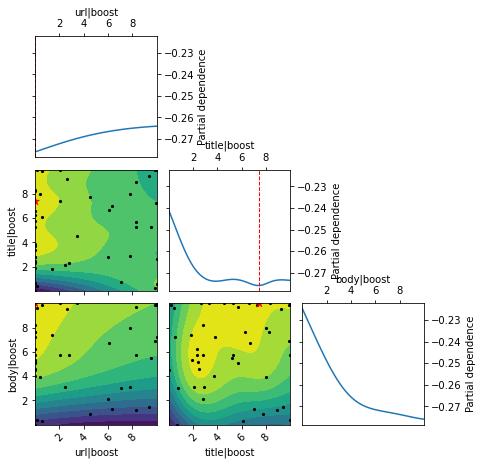

In [8]:
_ = plot_objective(metadata, sample_source='result')

In [9]:
%%time

_ = evaluate_mrr100_dev_templated(es, max_concurrent_searches, index, _templates, template_id, params=final_params)

Evaluation with: MRR@100
Score: 0.2976
CPU times: user 2.1 s, sys: 658 ms, total: 2.76 s
Wall time: 2min 25s


In [10]:
final_params

{'url|boost': 0.0, 'title|boost': 7.4224836373211005, 'body|boost': 10.0}

### Base fields + bigrams

In [11]:
_field_names = [
    'url',
    'title', 'title.bigrams',
    'body', 'body.bigrams',
]
_templates = deepcopy(base_templates)
_match_queries = [match_query(x) for x in _field_names]
_templates[0]['template']['source']['query']['bool'] = { 'should': _match_queries }

In [12]:
%%time

_ = evaluate_mrr100_dev_templated(es, max_concurrent_searches, index, _templates, template_id, params={
    'url|boost': 1.0,
    'title|boost': 1.0,
    'title_bigrams|boost': 1.0,
    'body|boost': 1.0,
    'body_bigrams|boost': 1.0,
})

Evaluation with: MRR@100
Score: 0.2696
CPU times: user 2 s, sys: 469 ms, total: 2.47 s
Wall time: 5min 17s


In [13]:
%%time

_, _, final_params, metadata = optimize_query_mrr100_templated(es, max_concurrent_searches, index, _templates, template_id,
    config_space=Config.parse({
        'method': 'bayesian',
        'num_iterations': 50,
        'num_initial_points': 20,
        'space': {
            'url|boost': { 'low': 0.0, 'high': 10.0 },
            'title|boost': { 'low': 0.0, 'high': 10.0 },
            'title_bigrams|boost': { 'low': 0.0, 'high': 10.0 },
            'body|boost': { 'low': 0.0, 'high': 10.0 },
            'body_bigrams|boost': { 'low': 0.0, 'high': 10.0 },
        }
    }))

Optimizing parameters
 - metric: MRR@100
 - queries: data/msmarco-document-sampled-queries.1000.tsv
 - queries: data/msmarco/document/msmarco-doctrain-qrels.tsv
 > iteration 1/50, took 0:01:07 (remains: 0:55:19)
   | 0.2514 (best: 0.2514) - {'url|boost': 5.3156102464480615, 'title|boost': 6.093117674508318, 'title_bigrams|boost': 0.0980657889274872, 'body|boost': 3.5926238667815364, 'body_bigrams|boost': 7.439154932530904}
 > iteration 2/50, took 0:01:09 (remains: 0:55:14)
   | 0.2504 (best: 0.2514) - {'url|boost': 9.454092716557145, 'title|boost': 4.911697195266615, 'title_bigrams|boost': 2.6443576650498883, 'body|boost': 2.873032552074825, 'body_bigrams|boost': 5.429867134003954}
 > iteration 3/50, took 0:01:15 (remains: 0:58:51)
   | 0.2591 (best: 0.2591) - {'url|boost': 9.189714620484683, 'title|boost': 0.08193572562694153, 'title_bigrams|boost': 3.3200856235436267, 'body|boost': 8.389343184645242, 'body_bigrams|boost': 0.9512096420261409}
 > iteration 4/50, took 0:01:11 (remains: 

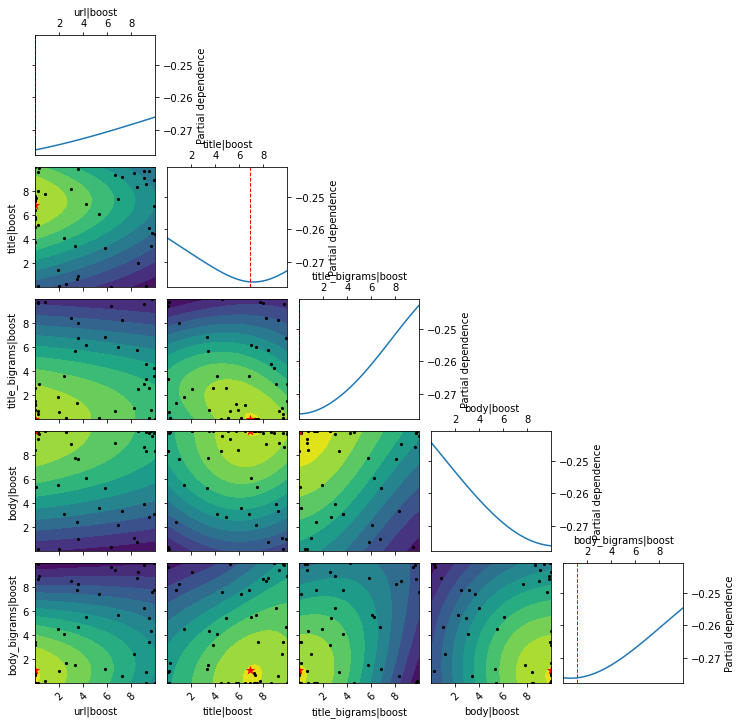

In [14]:
_ = plot_objective(metadata, sample_source='result')

In [15]:
%%time

_ = evaluate_mrr100_dev_templated(es, max_concurrent_searches, index, _templates, template_id, params=final_params)

Evaluation with: MRR@100
Score: 0.2982
CPU times: user 1.79 s, sys: 715 ms, total: 2.5 s
Wall time: 5min 42s


In [16]:
final_params

{'url|boost': 0.0,
 'title|boost': 6.858095392186523,
 'title_bigrams|boost': 0.0,
 'body|boost': 10.0,
 'body_bigrams|boost': 1.1023075601019108}

### Base fields + expansions

In [17]:
_field_names = [
    'url',
    'title',
    'body',
    'expansions',
]
_templates = deepcopy(base_templates)
_match_queries = [match_query(x) for x in _field_names]
_templates[0]['template']['source']['query']['bool'] = { 'should': _match_queries }

In [18]:
%%time

_ = evaluate_mrr100_dev_templated(es, max_concurrent_searches, index, _templates, template_id, params={
    'url|boost': 1.0,
    'title|boost': 1.0,
    'body|boost': 1.0,
    'expansions|boost': 1.0,
})

Evaluation with: MRR@100
Score: 0.3269
CPU times: user 2.45 s, sys: 853 ms, total: 3.3 s
Wall time: 3min


In [19]:
%%time

_, _, final_params, metadata = optimize_query_mrr100_templated(es, max_concurrent_searches, index, _templates, template_id,
    config_space=Config.parse({
        'method': 'bayesian',
        'num_iterations': 50,
        'num_initial_points': 20,
        'space': {
            'url|boost': { 'low': 0.0, 'high': 10.0 },
            'title|boost': { 'low': 0.0, 'high': 10.0 },
            'body|boost': { 'low': 0.0, 'high': 10.0 },
            'expansions|boost': { 'low': 0.0, 'high': 10.0 },
        }
    }))

Optimizing parameters
 - metric: MRR@100
 - queries: data/msmarco-document-sampled-queries.1000.tsv
 - queries: data/msmarco/document/msmarco-doctrain-qrels.tsv
 > iteration 1/50, took 0:00:41 (remains: 0:33:41)
   | 0.2794 (best: 0.2794) - {'url|boost': 6.9748458742167525, 'title|boost': 4.238706364735894, 'body|boost': 0.17615276307859198, 'expansions|boost': 3.568841146789576}
 > iteration 2/50, took 0:00:34 (remains: 0:27:15)
   | 0.2908 (best: 0.2908) - {'url|boost': 6.805907666457688, 'title|boost': 7.393400222581557, 'body|boost': 2.8558504745598317, 'expansions|boost': 6.388968299508182}
 > iteration 3/50, took 0:00:28 (remains: 0:22:26)
   | 0.3000 (best: 0.3000) - {'url|boost': 8.996924770640076, 'title|boost': 0.7295872361530144, 'body|boost': 9.964784380131032, 'expansions|boost': 4.80824836418291}
 > iteration 4/50, took 0:00:33 (remains: 0:25:20)
   | 0.2660 (best: 0.3000) - {'url|boost': 7.438274874059886, 'title|boost': 3.991898988888561, 'body|boost': 4.620734859466459

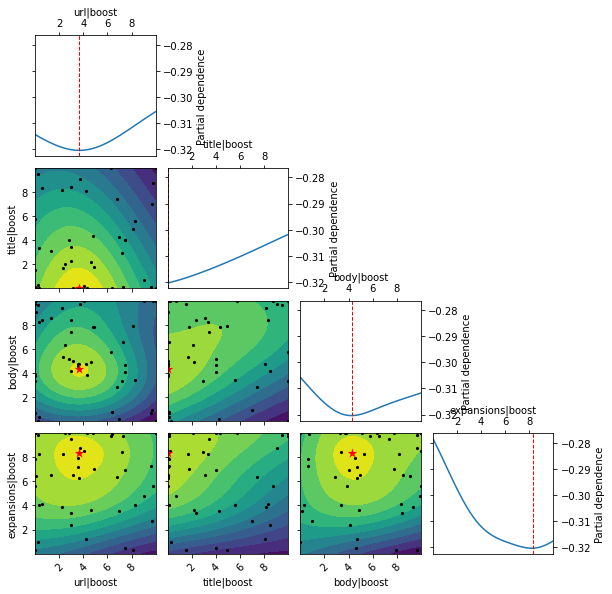

In [20]:
_ = plot_objective(metadata, sample_source='result')

In [21]:
%%time

_ = evaluate_mrr100_dev_templated(es, max_concurrent_searches, index, _templates, template_id, params=final_params)

Evaluation with: MRR@100
Score: 0.3355
CPU times: user 1.83 s, sys: 560 ms, total: 2.39 s
Wall time: 2min 46s


In [22]:
final_params

{'url|boost': 3.620342122510767,
 'title|boost': 0.0,
 'body|boost': 4.326499660677731,
 'expansions|boost': 8.329101716099403}

### Base fields + expansions + bigrams

In [23]:
_field_names = [
    'url',
    'title', 'title.bigrams',
    'body', 'body.bigrams',
    'expansions', 'expansions.bigrams',
]
_templates = deepcopy(base_templates)
_match_queries = [match_query(x) for x in _field_names]
_templates[0]['template']['source']['query']['bool'] = { 'should': _match_queries }

In [24]:
%%time

_ = evaluate_mrr100_dev_templated(es, max_concurrent_searches, index, _templates, template_id, params={
    'url|boost': 1.0,
    'title|boost': 1.0,
    'title_bigrams|boost': 1.0,
    'body|boost': 1.0,
    'body_bigrams|boost': 1.0,
    'expansions|boost': 1.0,
    'expansions_bigrams|boost': 1.0
})

Evaluation with: MRR@100
Score: 0.3203
CPU times: user 2.11 s, sys: 720 ms, total: 2.83 s
Wall time: 7min 10s


In [45]:
%%time

_, _, final_params, metadata = optimize_query_mrr100_templated(es, max_concurrent_searches, index, _templates, template_id,
    config_space=Config.parse({
        'method': 'bayesian',
        'num_iterations': 50,
        'num_initial_points': 20,
        'space': {
            'url|boost': { 'low': 0.0, 'high': 10.0 },
            'title|boost': { 'low': 0.0, 'high': 10.0 },
            'title_bigrams|boost': { 'low': 0.0, 'high': 10.0 },
            'body|boost': { 'low': 0.0, 'high': 10.0 },
            'body_bigrams|boost': { 'low': 0.0, 'high': 10.0 },
            'expansions|boost': { 'low': 0.0, 'high': 10.0 },
            'expansions_bigrams|boost': { 'low': 0.0, 'high': 10.0 },
        }
    }))

Optimizing parameters
 - metric: MRR@100
 - queries: data/msmarco-document-sampled-queries.1000.tsv
 - queries: data/msmarco/document/msmarco-doctrain-qrels.tsv
 > iteration 1/50, took 0:01:33 (remains: 1:16:06)
   | 0.2858 (best: 0.2858) - {'url|boost': 7.1541679958330615, 'title|boost': 7.940231583168092, 'title_bigrams|boost': 8.3662277757047, 'body|boost': 8.026723351132606, 'body_bigrams|boost': 6.059360765028254, 'expansions|boost': 2.096196400438301, 'expansions_bigrams|boost': 2.408668022898794}
 > iteration 2/50, took 0:01:18 (remains: 1:02:26)
   | 0.2896 (best: 0.2896) - {'url|boost': 5.070987936271921, 'title|boost': 3.365360898963276, 'title_bigrams|boost': 3.7195651035687587, 'body|boost': 2.6840194968236313, 'body_bigrams|boost': 9.664545562890144, 'expansions|boost': 4.846790302413292, 'expansions_bigrams|boost': 7.1266945127887205}
 > iteration 3/50, took 0:01:24 (remains: 1:05:59)
   | 0.3018 (best: 0.3018) - {'url|boost': 7.821934651980601, 'title|boost': 0.599750969

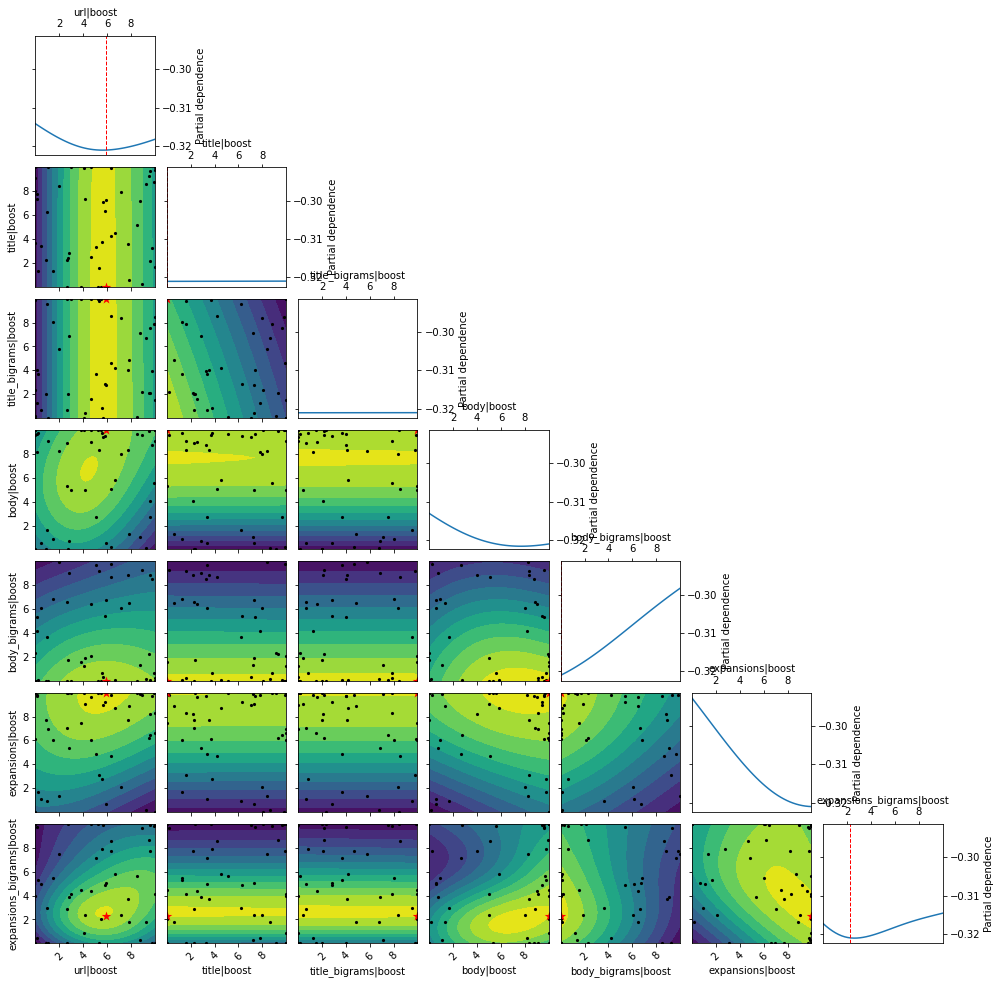

In [46]:
_ = plot_objective(metadata, sample_source='result')

In [47]:
%%time

_ = evaluate_mrr100_dev_templated(es, max_concurrent_searches, index, _templates, template_id, params=final_params)

Evaluation with: MRR@100
Score: 0.3407
CPU times: user 2.58 s, sys: 885 ms, total: 3.46 s
Wall time: 7min 10s


In [48]:
final_params

{'url|boost': 5.949038063682114,
 'title|boost': 0.0,
 'title_bigrams|boost': 10.0,
 'body|boost': 10.0,
 'body_bigrams|boost': 0.0,
 'expansions|boost': 10.0,
 'expansions_bigrams|boost': 2.2577356135425655}

In [49]:
# with 100/20 iterations
# 0.3412

{
    'url|boost': 6.831285778689427,
    'title|boost': 0.0,
    'title_bigrams|boost': 0.0,
    'body|boost': 10.0,
    'body_bigrams|boost': 10.0,
    'expansions|boost': 10.0,
    'expansions_bigrams|boost': 3.348671601852749
}

{'url|boost': 6.831285778689427,
 'title|boost': 0.0,
 'title_bigrams|boost': 0.0,
 'body|boost': 10.0,
 'body_bigrams|boost': 10.0,
 'expansions|boost': 10.0,
 'expansions_bigrams|boost': 3.348671601852749}

### Selective fields

Based on the results from above, remove fields with `0` boost values.

In [50]:
_field_names = [
    'url',
    'body', 'body.bigrams',
    'expansions', 'expansions.bigrams',
]
_templates = deepcopy(base_templates)
_match_queries = [match_query(x) for x in _field_names]
_templates[0]['template']['source']['query']['bool'] = { 'should': _match_queries }

In [51]:
%%time

_ = evaluate_mrr100_dev_templated(es, max_concurrent_searches, index, _templates, template_id, params={
    'url|boost': 1.0,
    'body|boost': 1.0,
    'body_bigrams|boost': 1.0,
    'expansions|boost': 1.0,
    'expansions_bigrams|boost': 1.0
})

Evaluation with: MRR@100
Score: 0.3318
CPU times: user 2.81 s, sys: 1.02 s, total: 3.83 s
Wall time: 7min 6s


In [52]:
%%time

_, _, final_params, metadata = optimize_query_mrr100_templated(es, max_concurrent_searches, index, _templates, template_id,
    config_space=Config.parse({
        'method': 'bayesian',
        'num_iterations': 50,
        'num_initial_points': 20,
        'space': {
            'url|boost': { 'low': 0.0, 'high': 10.0 },
            'body|boost': { 'low': 0.0, 'high': 10.0 },
            'body_bigrams|boost': { 'low': 0.0, 'high': 10.0 },
            'expansions|boost': { 'low': 0.0, 'high': 10.0 },
            'expansions_bigrams|boost': { 'low': 0.0, 'high': 10.0 },
        }
    }))

Optimizing parameters
 - metric: MRR@100
 - queries: data/msmarco-document-sampled-queries.1000.tsv
 - queries: data/msmarco/document/msmarco-doctrain-qrels.tsv
 > iteration 1/50, took 0:01:25 (remains: 1:09:57)
   | 0.3013 (best: 0.3013) - {'url|boost': 7.73888589006612, 'body|boost': 4.436038965405219, 'body_bigrams|boost': 9.102205111489042, 'expansions|boost': 8.755400621407274, 'expansions_bigrams|boost': 3.156355776262973}
 > iteration 2/50, took 0:01:22 (remains: 1:06:21)
   | 0.2958 (best: 0.3013) - {'url|boost': 1.794434933192868, 'body|boost': 2.6819317445848996, 'body_bigrams|boost': 5.544134107110398, 'expansions|boost': 4.089206898889976, 'expansions_bigrams|boost': 5.040054940360228}
 > iteration 3/50, took 0:01:25 (remains: 1:07:13)
   | 0.2985 (best: 0.3013) - {'url|boost': 3.8641685177591234, 'body|boost': 7.1169105371480255, 'body_bigrams|boost': 2.9206650569974286, 'expansions|boost': 0.5678349774701442, 'expansions_bigrams|boost': 8.000572950130522}
 > iteration 4/5

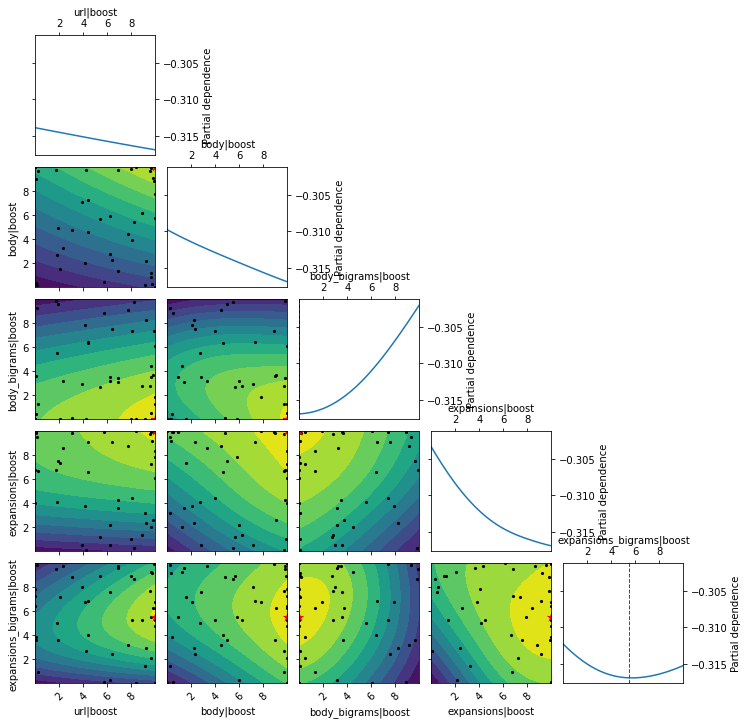

In [53]:
_ = plot_objective(metadata, sample_source='result')

In [54]:
%%time

_ = evaluate_mrr100_dev_templated(es, max_concurrent_searches, index, _templates, template_id, params=final_params)

Evaluation with: MRR@100
Score: 0.3402
CPU times: user 2.71 s, sys: 997 ms, total: 3.7 s
Wall time: 7min 7s


In [55]:
final_params

{'url|boost': 10.0,
 'body|boost': 10.0,
 'body_bigrams|boost': 0.0,
 'expansions|boost': 10.0,
 'expansions_bigrams|boost': 5.500040511164799}

In [56]:
# with 50/20 iterations
# 0.3415

{
    'url|boost': 5.906335138830406,
    'body|boost': 7.285007082865544,
    'body_bigrams|boost': 0.1561216257683724,
    'expansions|boost': 9.922407448775347,
    'expansions_bigrams|boost': 4.5189511755570635
}

{'url|boost': 5.906335138830406,
 'body|boost': 7.285007082865544,
 'body_bigrams|boost': 0.1561216257683724,
 'expansions|boost': 9.922407448775347,
 'expansions_bigrams|boost': 4.5189511755570635}